In [1]:
# %pip install -U pip
# %pip install accelerate==0.20.3
# %pip install appdirs==1.4.4
# %pip install bitsandbytes==0.37.2
# %pip install datasets==2.10.1
# %pip install fire==0.5.0
# %pip install git+https://github.com/huggingface/peft.git
# %pip install git+https://github.com/huggingface/transformers.git
# %pip install torch==2.0.0
# %pip install sentencepiece==0.1.97
# %pip install tensorboardX==2.6
# %pip install gradio==3.23.0

In [1]:
import transformers
from transformers import LlamaTokenizer, LlamaForCausalLM
from typing import List
import torch
from torch import cuda, bfloat16
from datasets import load_dataset
import pandas as pd
 
import matplotlib.pyplot as plt
import matplotlib as mpl
# import seaborn as sns
from pylab import rcParams
# from trl import SFTTrainer
 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [2]:
df = pd.read_csv("hate_speech.csv")
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


0 - hate speech

1 - offensive language

2 - neither

In [3]:
def class_score_to_name(score: int):
    if score == 0:
        return "Hate speech"
    elif score == 1:
        return "Offensive language"
    return "Neither"
 
dataset_data = [
    {
        "instruction": "Classify the tweet.",
        "input": row_dict["tweet"],
        "output": class_score_to_name(row_dict["class"])
    }
    for row_dict in df.to_dict(orient="records")
]
 
dataset_data[0]

{'instruction': 'Classify the tweet.',
 'input': "!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...",
 'output': 'Neither'}

In [4]:
import json
with open("alpaca-hatespeech-dataset.json", "w") as f:
   json.dump(dataset_data, f)

In [1]:
BASE_MODEL = 'meta-llama/Llama-2-13b-chat-hf'

model_config = transformers.AutoConfig.from_pretrained(
    BASE_MODEL,
    use_auth_token=hf_auth
)

bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_compute_dtype=bfloat16
)


model = transformers.AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    trust_remote_code=True,
    config=model_config,
    quantization_config=bnb_config,
    device_map='auto',
    use_auth_token=hf_auth
)

tokenizer = transformers.AutoTokenizer.from_pretrained(
    BASE_MODEL,
    use_auth_token=hf_auth
)
 
tokenizer.pad_token_id = (0)
tokenizer.padding_side = "left"

NameError: name 'transformers' is not defined

In [3]:
tokenizer.convert_tokens_to_ids(['talk', ':'])

[0, 29901]

In [4]:
data = load_dataset("json", data_files="alpaca-hatespeech-dataset.json")
data["train"]

Found cached dataset json (/home/hb/.cache/huggingface/datasets/json/default-7d082948e3a5e9d8/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51)


  0%|          | 0/1 [00:00<?, ?it/s]

Dataset({
    features: ['instruction', 'input', 'output'],
    num_rows: 24783
})

In [5]:
CUTOFF_LEN = 256

def generate_prompt(data_point):
    return f"""Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.  # noqa: E501
### Instruction:
{data_point["instruction"]}
### Input:
{data_point["input"]}
### Response:
{data_point["output"]}"""
 
 
def tokenize(prompt, add_eos_token=True):
    result = tokenizer(
        prompt,
        truncation=True,
        max_length=CUTOFF_LEN,
        padding=False,
        return_tensors=None,
    )
    if (
        result["input_ids"][-1] != tokenizer.eos_token_id
        and len(result["input_ids"]) < CUTOFF_LEN
        and add_eos_token
    ):
        result["input_ids"].append(tokenizer.eos_token_id)
        result["attention_mask"].append(1)
 
    result["labels"] = result["input_ids"].copy()
 
    return result
 
def generate_and_tokenize_prompt(data_point):
    full_prompt = generate_prompt(data_point)
    tokenized_full_prompt = tokenize(full_prompt)
    return tokenized_full_prompt

In [6]:
train_val = data["train"].train_test_split(
    test_size=3000, shuffle=True, seed=42
)
train_data = (
    train_val["train"].map(generate_and_tokenize_prompt)
)
val_data = (
    train_val["test"].map(generate_and_tokenize_prompt)
)

Loading cached split indices for dataset at /home/hb/.cache/huggingface/datasets/json/default-7d082948e3a5e9d8/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-c7eb0f90a764b996.arrow and /home/hb/.cache/huggingface/datasets/json/default-7d082948e3a5e9d8/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-c21827320fefba2f.arrow
Loading cached processed dataset at /home/hb/.cache/huggingface/datasets/json/default-7d082948e3a5e9d8/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-3936ed72c2e7389f.arrow
Loading cached processed dataset at /home/hb/.cache/huggingface/datasets/json/default-7d082948e3a5e9d8/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-07ff7c05c6d0eccf.arrow


In [7]:
from peft import LoraConfig, get_peft_model
from transformers import TrainingArguments

lora_alpha = 16
lora_dropout = 0.1
lora_r = 64

peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM"
)

output_dir = "./hatespeech"
per_device_train_batch_size = 4
gradient_accumulation_steps = 4
optim = "paged_adamw_32bit"
save_steps = 100
logging_steps = 10
learning_rate = 2e-4
max_grad_norm = 0.3
max_steps = 100
warmup_ratio = 0.03
lr_scheduler_type = "constant"

training_arguments = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    fp16=True,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=True,
    lr_scheduler_type=lr_scheduler_type,
)

In [8]:
data_collator = transformers.DataCollatorForSeq2Seq(
    tokenizer, pad_to_multiple_of=8, return_tensors="pt", padding=True
)

In [9]:
from trl import SFTTrainer

max_seq_length = 512

trainer = SFTTrainer(
    model=model,
    train_dataset=train_data,
    eval_dataset=val_data,
    peft_config=peft_config,
    dataset_text_field="output",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
)

# trainer = transformers.Trainer(
#     model=model,
#     train_dataset=train_data,
#     eval_dataset=val_data,
#     args=training_arguments,
#     data_collator=data_collator
# )

/home/hb/myenv/lib/python3.8/site-packages/peft/utils/other.py:102: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(


Map:   0%|          | 0/21783 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [10]:
trainer.train()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /home/hb/.netrc


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Step,Training Loss


TrainOutput(global_step=100, training_loss=1.7041603761911392, metrics={'train_runtime': 335.9255, 'train_samples_per_second': 4.763, 'train_steps_per_second': 0.298, 'total_flos': 240904068710400.0, 'train_loss': 1.7041603761911392, 'epoch': 0.07})

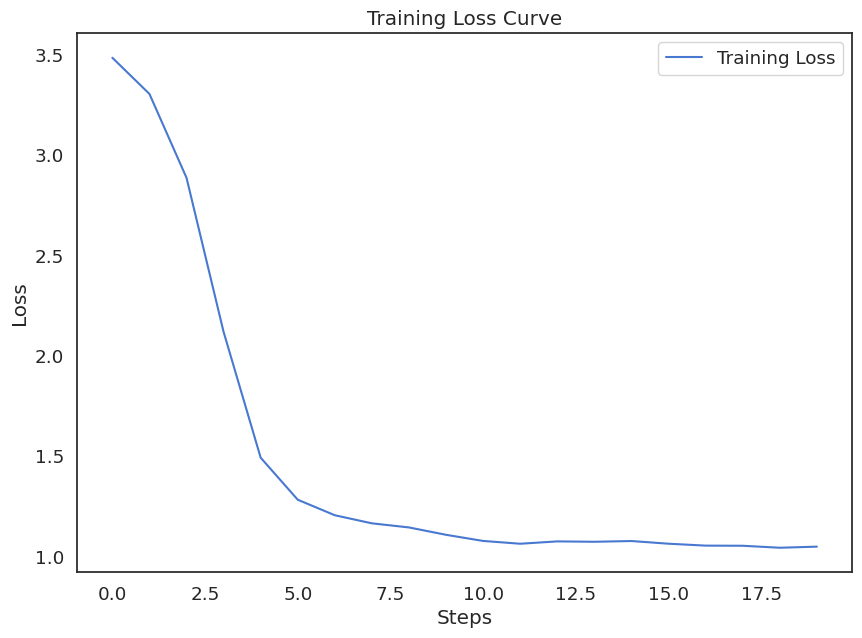

In [ ]:
import json
import matplotlib.pyplot as plt

with open("hate_speech_exp/checkpoint-200/trainer_state.json", "r") as f:
    trainer_state = json.load(f)


log_history = trainer_state["log_history"]
train_loss_values = [entry["loss"] for entry in log_history if "loss" in entry]
train_acc_values = [entry["accuracy"] for entry in log_history if "accuracy" in entry]

plt.plot(train_loss_values, label="Training Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.show()
